### Preliminaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn 
import torch.nn.functional as F
from torch import optim
from torch.autograd import grad
from scipy.io import loadmat

from argparse import Namespace
from functools import reduce
import seaborn as sns
import pickle

import pandas as pd
from matplotlib.colors import LogNorm, Normalize

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/229 Project'

Mounted at /content/drive
/content/drive/My Drive/229 Project


In [ ]:
# install DeepXDE
%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.6 MB/s eta 0:00:00


In [ ]:
# import packages
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow.compat.v1")

import deepxde as dde
import numpy as np

from deepxde.backend import tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import random

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fourier Helper Functions

In [ ]:
def get_fft(y, sampling_rate):

  y = y.squeeze()

  # Calculate the Fourier transform of f(x)
  fourier = np.fft.fft(y.squeeze())

  length = len(y)

  # Calculate the corresponding frequencies
  freq = np.fft.fftfreq(length, 1/sampling_rate)

  results = list(zip(freq, np.abs(fourier)))
  filtered = [(x, y) for (x, y) in results if x > 0]
  results = list(zip(*filtered))

  return results

### Computing the Wasserstein Distance

In [ ]:
def wasserstein_dist(first_amps, second_amps, clip=True):
  first_amps = first_amps/sum(first_amps)
  second_amps = second_amps/sum(second_amps)

  first_cdf = np.cumsum(first_amps)
  second_cdf = np.cumsum(second_amps)

  if clip:
    return sum(abs(first_cdf - second_cdf))/len(first_cdf) + 1e-3
  else:
    return sum(abs(first_cdf - second_cdf))/len(first_cdf)

In [ ]:
def get_pairwise_dists(solution, domain_len, num_x):
  results = {"time_one": [], "time_two": [], "value": []}
  results_matrix = np.empty((100, 100))

  for index, t_1 in enumerate(list(np.linspace(0, 0.99, 100))):
      for index_2, t_2 in enumerate(list(np.linspace(0, 0.99, 100))):
        start_1 = round(num_x * t_1 * 100)
        end_1 = start_1 + num_x

        start_2 = round(num_x * t_2 * 100)
        end_2 = start_2 + num_x

        _, fourier_1 = get_fft(solution[start_1:end_1], num_x/domain_len)
        _, fourier_2 = get_fft(solution[start_2:end_2], num_x/domain_len)

        results['time_one'].append(t_1)
        results['time_two'].append(t_2)
        results['value'].append(wasserstein_dist(fourier_1, fourier_2))

        results_matrix[index][index_2] = wasserstein_dist(fourier_1, fourier_2, clip=False)

  return results, results_matrix

In [ ]:
def plot_wasserstein(true_sol, pred_sol, domain_len, num_x=256):

    true_sol = true_sol.squeeze()
    pred_sol = pred_sol.squeeze()

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

    true_dict, _ = get_pairwise_dists(true_sol, domain_len, num_x)
    pred_dict, _ = get_pairwise_dists(pred_sol, domain_len, num_x)

    true_dists = pd.DataFrame(data = true_dict)
    true_dists = true_dists.round(3)
    true_dists = true_dists.pivot("time_one", "time_two", "value")
    sns.heatmap(true_dists, yticklabels=3, xticklabels=10, norm=LogNorm(), cbar_kws={'label': 'Wasserstein Distance between Spectra'}, ax=ax0, cmap="BuPu")
    ax0.invert_yaxis()
    ax0.set_xlabel("Time")
    ax0.set_ylabel("Time")
    ax0.set_title(f"Analyzing Spectrum Evolution of True Solution")

    pred_dists = pd.DataFrame(data = pred_dict)
    pred_dists = pred_dists.round(3)
    pred_dists = pred_dists.pivot("time_one", "time_two", "value")
    sns.heatmap(pred_dists, yticklabels=3, xticklabels=10, norm=LogNorm(), cbar_kws={'label': 'Wasserstein Distance between Spectra'}, ax=ax1, cmap="BuPu")
    ax1.invert_yaxis()
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Time")
    ax1.set_title(f"Analyzing Spectrum Evolution of Predicted Solution")
    plt.show()

    diff_dists = abs(true_dists.sub(pred_dists))
    sns.heatmap(diff_dists, yticklabels=3, xticklabels=10, norm=LogNorm(), cbar_kws={'label': 'Wasserstein Distance between Spectra'}, cmap="BuPu")
    plt.xlabel("Time")
    plt.ylabel("Time")
    plt.title(f"Difference in Wasserstein Distances b/w True and Predicted")
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
def get_diff_dists(true_sol, pred_sol, domain_len, num_x=256):
  true_sol = true_sol.squeeze()
  pred_sol = pred_sol.squeeze()

  _, true_matrix = get_pairwise_dists(true_sol, domain_len, num_x)
  _, pred_matrix = get_pairwise_dists(pred_sol, domain_len, num_x)

  return true_matrix - pred_matrix

### Burgers' Equation

#### Generating True Solution

In [ ]:
# import data for the true solution
def gen_testdata_burgers():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

In [ ]:
# compare the true solution with the predicted solution
X_burgers, y_true_burgers = gen_testdata_burgers()
y_true_burgers = y_true_burgers.squeeze()

# with open('model_preds_full_domain.pkl', 'rb') as f:
#     all_preds = pickle.load(f)

with open('long_model_preds.pkl', 'rb') as f:
    all_preds_burgers = pickle.load(f)

#### Plotting Wasserstein Distance

<ipython-input-8-57e6a30ad7aa>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  true_dists = true_dists.pivot("time_one", "time_two", "value")
<ipython-input-8-57e6a30ad7aa>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pred_dists = pred_dists.pivot("time_one", "time_two", "value")


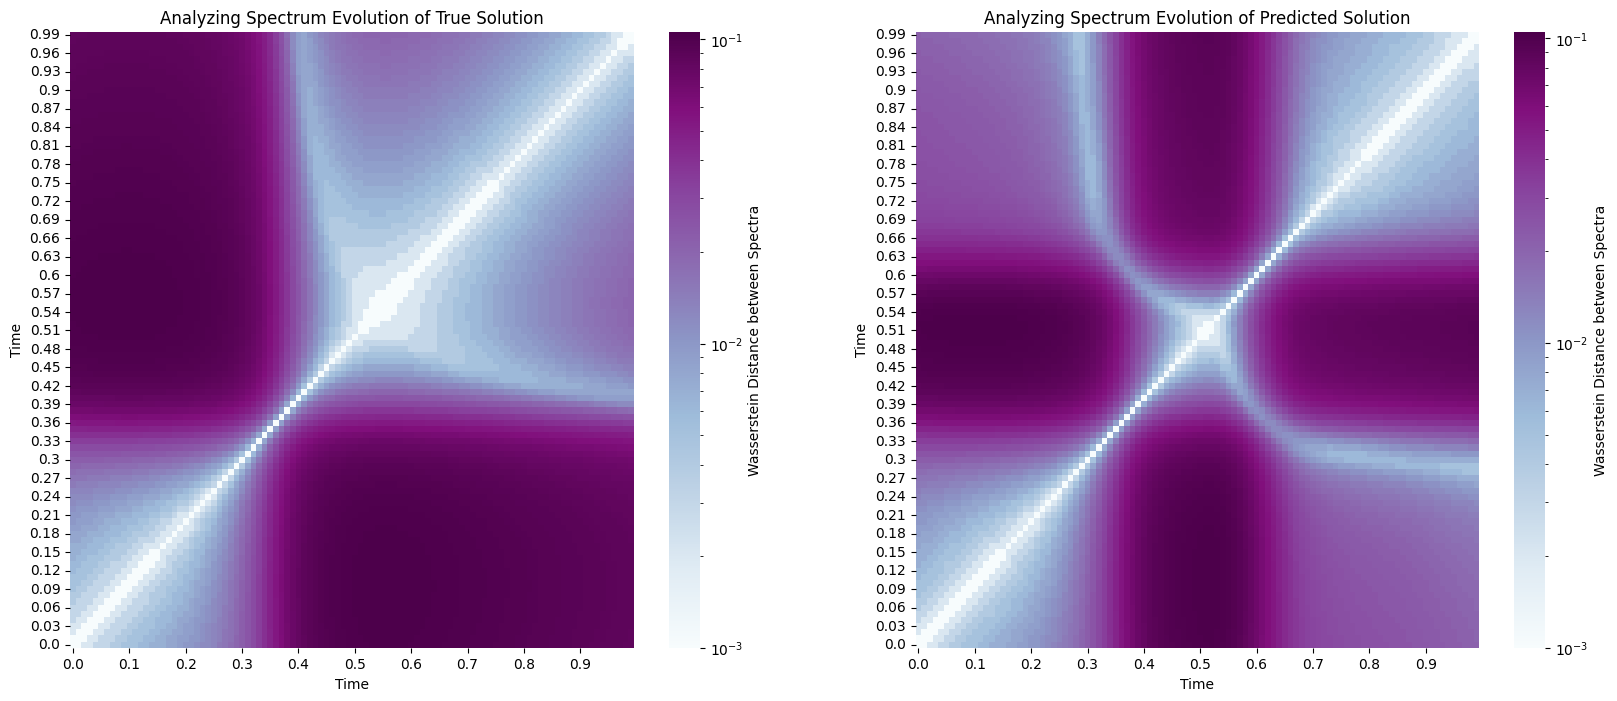

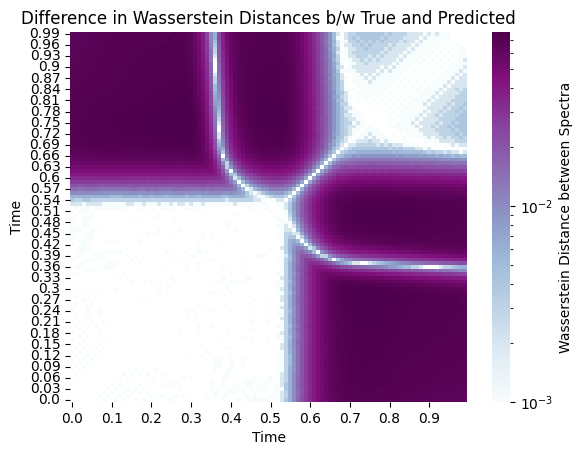

In [ ]:
plot_wasserstein(y_true_burgers, all_preds_burgers[500000], domain_len=2, num_x=256)

### Allen-Cahn Equation

#### Generating True Solution

In [ ]:
def gen_testdata_ac():
    data = loadmat("Allen_Cahn.mat")

    t = data["t"]
    x = data["x"]
    u = data["u"]

    dt = dx = 0.01
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y

In [ ]:
X_ac, y_true_ac = gen_testdata_ac()
y_true_ac = y_true_ac.squeeze()

with open('model_preds_allen_cahn.pkl', 'rb') as f:
    all_preds_ac = pickle.load(f)

#### Plotting Wasserstein Distance

<ipython-input-8-57e6a30ad7aa>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  true_dists = true_dists.pivot("time_one", "time_two", "value")
<ipython-input-8-57e6a30ad7aa>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pred_dists = pred_dists.pivot("time_one", "time_two", "value")


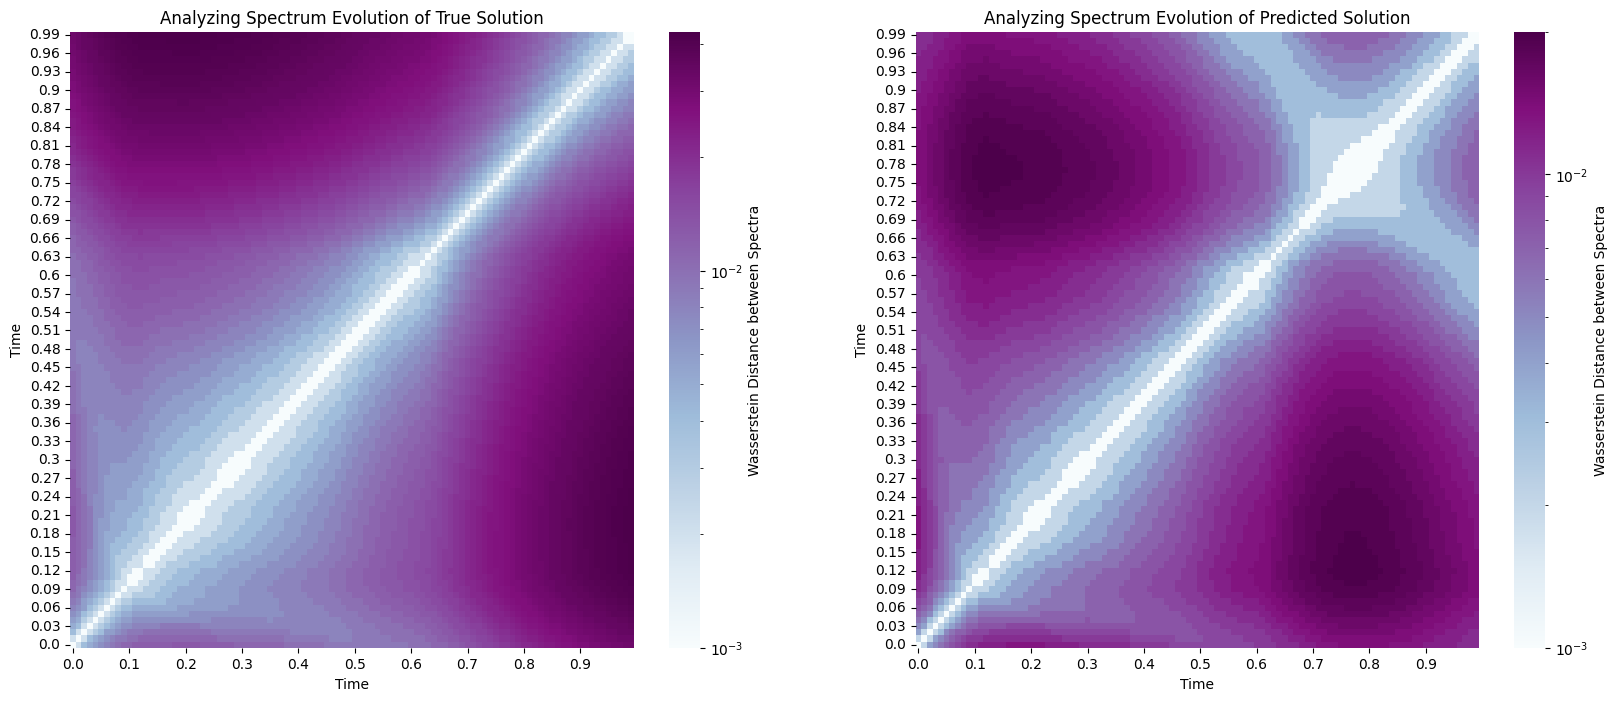

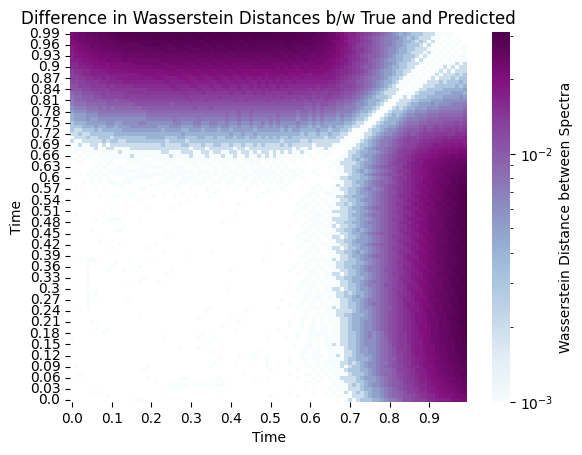

In [ ]:
plot_wasserstein(y_true_ac, all_preds_ac[500000], domain_len=2, num_x=201)

### Diffusion Equation

#### Generating True Solution

In [ ]:
# set up the problem
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0.5, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

In [ ]:
def gen_testdata_diff():
  full_domain = np.zeros(shape=(25600, 2))
  true_sol = np.zeros(shape=(25600,))
  for time_step in range(100):
    time = time_step * .01
    x = geom.uniform_points(256, True)
    t = np.full(256, time)
    x = np.hstack((x, t.reshape(-1, 1)))

    start = int(256 * time * 100)
    end = start + 256
    full_domain[start:end] = x

    ground_truth = np.exp(-time) * np.sin(np.pi * x[:, 0])
    true_sol[start:end] = ground_truth
  
  return full_domain, true_sol

In [ ]:
# compare the true solution with the predicted solution
X_diff, y_true_diff = gen_testdata_diff()

with open('long_model_preds_diffusion.pkl', 'rb') as f:
    all_preds_diff = pickle.load(f)

#### Plotting Wasserstein Distance

<ipython-input-8-57e6a30ad7aa>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  true_dists = true_dists.pivot("time_one", "time_two", "value")
<ipython-input-8-57e6a30ad7aa>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pred_dists = pred_dists.pivot("time_one", "time_two", "value")


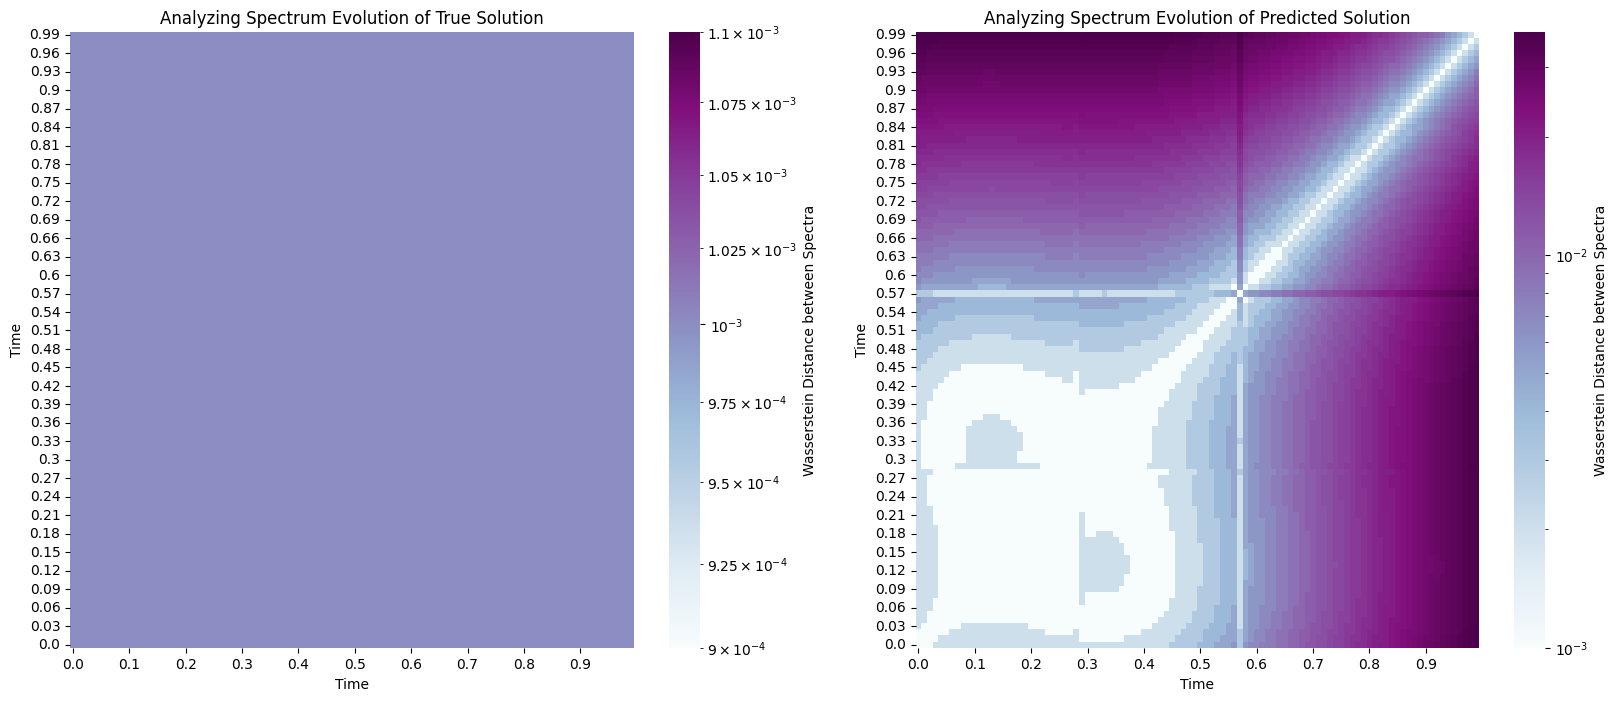

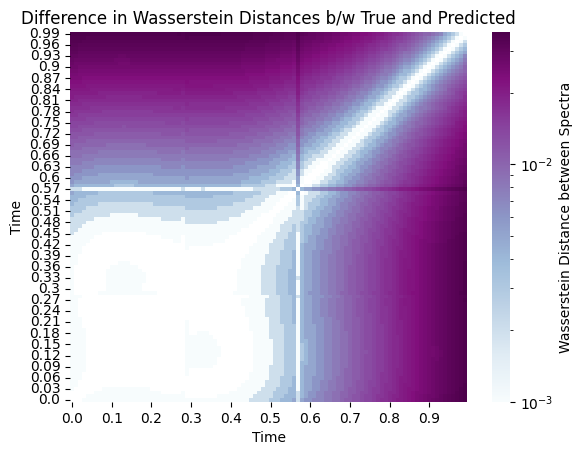

In [ ]:
plot_wasserstein(y_true_diff, all_preds_diff[500000], domain_len=2, num_x=256)

### Diffusion-Reaction Equation

#### Generating True Solution

In [ ]:
# set up the problem

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    d = 1
    return (
        dy_t
        - d * dy_xx
        - tf.exp(-x[:, 1:])
        * (
            3 * tf.sin(2 * x[:, 0:1]) / 2
            + 8 * tf.sin(3 * x[:, 0:1]) / 3
            + 15 * tf.sin(4 * x[:, 0:1]) / 4
            + 63 * tf.sin(8 * x[:, 0:1]) / 8
        )
    )

def func(x):
    return np.exp(-x[:, 1:]) * (
        np.sin(x[:, 0:1])
        + np.sin(2 * x[:, 0:1]) / 2
        + np.sin(3 * x[:, 0:1]) / 3
        + np.sin(4 * x[:, 0:1]) / 4
        + np.sin(8 * x[:, 0:1]) / 8
    )


geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# define the boundary and initial conditions
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=320, num_boundary=20,
    num_initial=10, solution=func, num_test=10000)

In [ ]:
def gen_testdata_diffr():
  full_domain = np.zeros(shape=(25600, 2))
  true_sol = np.zeros(shape=(25600,))
  for time_step in range(100):
    time = time_step * .01
    x = geom.uniform_points(256, True)
    t = np.full(256, time)
    x = np.hstack((x, t.reshape(-1, 1)))

    start = int(256 * time * 100)
    end = start + 256
    full_domain[start:end] = x

    ground_truth = np.exp(-time) * (np.sin(x[:, 0]) + np.sin(2*x[:, 0])/2 + np.sin(3*x[:, 0])/3 + np.sin(4*x[:, 0])/4 + np.sin(8*x[:, 0])/8)
    true_sol[start:end] = ground_truth
  
  return full_domain, true_sol

In [ ]:
import pickle

# compare the true solution with the predicted solution
X_diffr, y_true_diffr = gen_testdata_diffr()

with open('model_preds_diffusion_reaction.pkl', 'rb') as f:
    all_preds_diffr = pickle.load(f)

#### Plotting Wasserstein Distance

<ipython-input-8-57e6a30ad7aa>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  true_dists = true_dists.pivot("time_one", "time_two", "value")
<ipython-input-8-57e6a30ad7aa>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pred_dists = pred_dists.pivot("time_one", "time_two", "value")


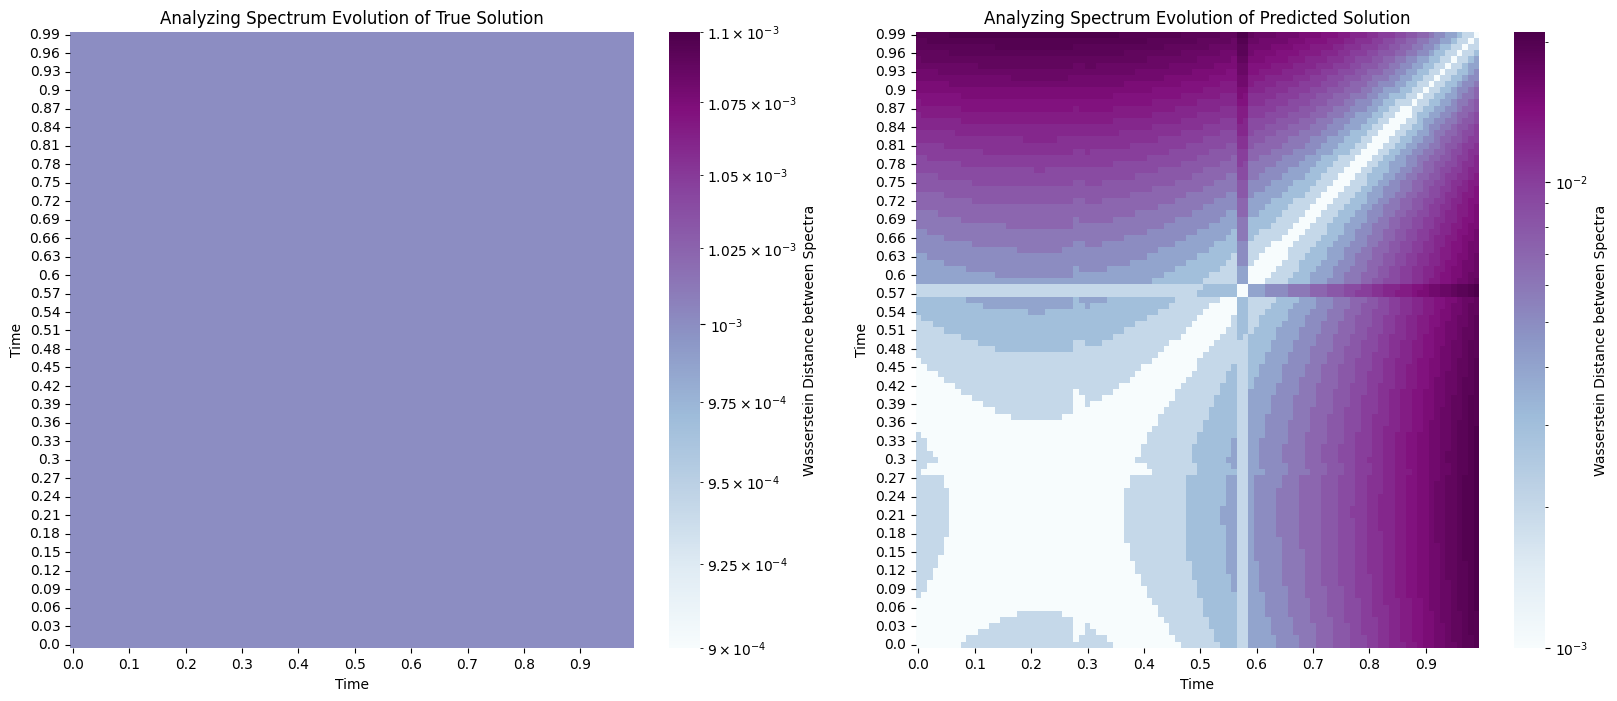

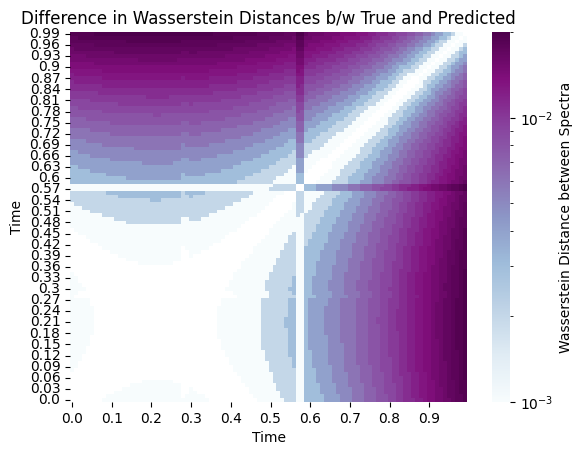

In [ ]:
plot_wasserstein(y_true_diffr, all_preds_diffr[500000], domain_len=2, num_x=256)

### Relationship with L2 Error

#### Helper Functions


In [ ]:
def l2_error(true_sol, predicted_sol, num_x):
  errors = []
  for t in np.linspace(0, 0.99, 100):
      start = round(num_x * t * 100)
      end = start + num_x
      errors.append(np.sum((true_sol[start:end] - predicted_sol[start:end]) ** 2)/num_x)

  return errors

In [ ]:
def plot_l2_error(true_sol, predicted_sol, num_x):
  errors = l2_error(true_sol, predicted_sol, num_x)
  plt.plot(np.linspace(0, 0.99, 100), errors)
  plt.xlabel("Time")
  plt.ylabel("L2 Error")

#### Get Pairwise Distance Matrices

In [ ]:
## Burgers'
burgers_matrix = get_diff_dists(y_true_burgers, all_preds_burgers[50000].squeeze(), domain_len=2, num_x=256)

## Allen-Cahn
ac_matrix = get_diff_dists(y_true_ac, all_preds_ac[500000].squeeze(), domain_len=2, num_x=200)

## Diffusion
diff_matrix = get_diff_dists(y_true_diff, all_preds_diff[50000].squeeze(), domain_len=2, num_x=256)

## Diffusion-Reaction
diffr_matrix = get_diff_dists(y_true_diffr, all_preds_diffr[500000].squeeze(), domain_len=2 * np.pi, num_x=256)

#### "One-Off" Distance

In [ ]:
def get_cumulative_dist(pairwise_matrix):

  cumulative_errors = [0]
  cumulative_error = 0

  for t1 in range(1, 100):
    cumulative_error += pairwise_matrix[t1 - 1][t1]
    cumulative_errors.append(cumulative_error)

  return cumulative_errors

In [ ]:
def plot_one_off(pairwise_matrix, true_sol, pred_sol, num_x, pde="Burgers'"):

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 7))

  # L2 Error Plot
  errors = l2_error(true_sol, pred_sol, num_x)
  ax0.plot(np.linspace(0, 0.99, 100), errors)
  ax0.set_xlabel("Time")
  ax0.set_ylabel("L2 Error")
  ax0.set_title(f"L2 Error for {pde}")

  # One-Off Plot
  one_off_distances = get_cumulative_dist(pairwise_matrix)
  ax1.plot(range(100), abs(np.array(one_off_distances)))
  ax1.set_xlabel("Time")
  ax1.set_ylabel("Cumulative Error")
  ax1.set_title(f"Cumulative Error in Wasserstein Distance for {pde}")

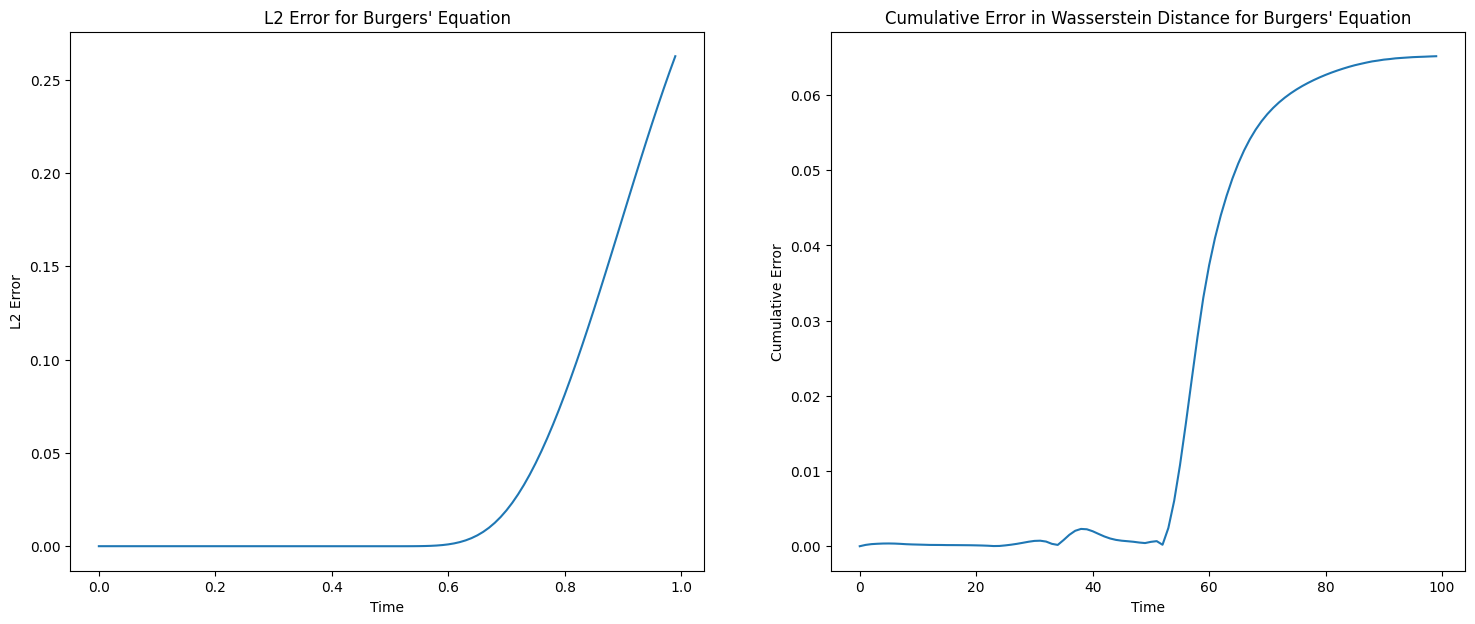

In [ ]:
plot_one_off(burgers_matrix, y_true_burgers, all_preds_burgers[50000].squeeze(), num_x=256, pde="Burgers' Equation")

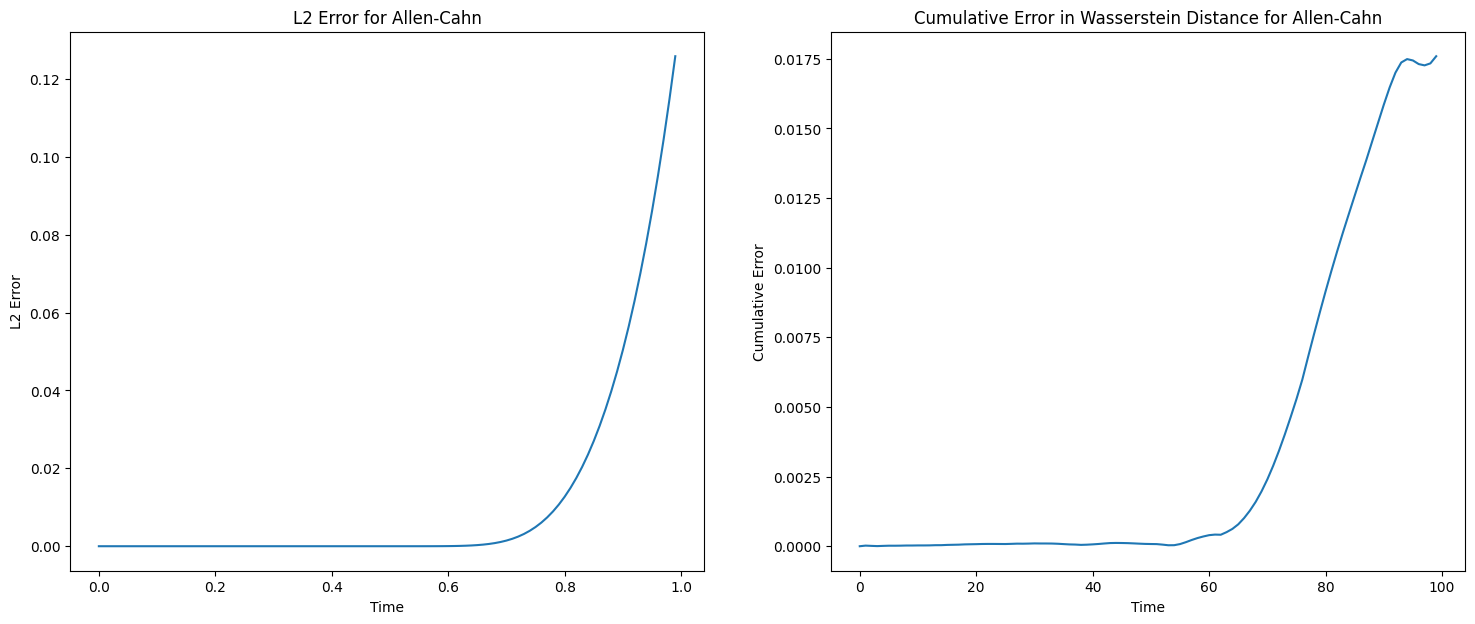

In [ ]:
plot_one_off(ac_matrix, y_true_ac, all_preds_ac[500000].squeeze(), num_x=201, pde="Allen-Cahn")

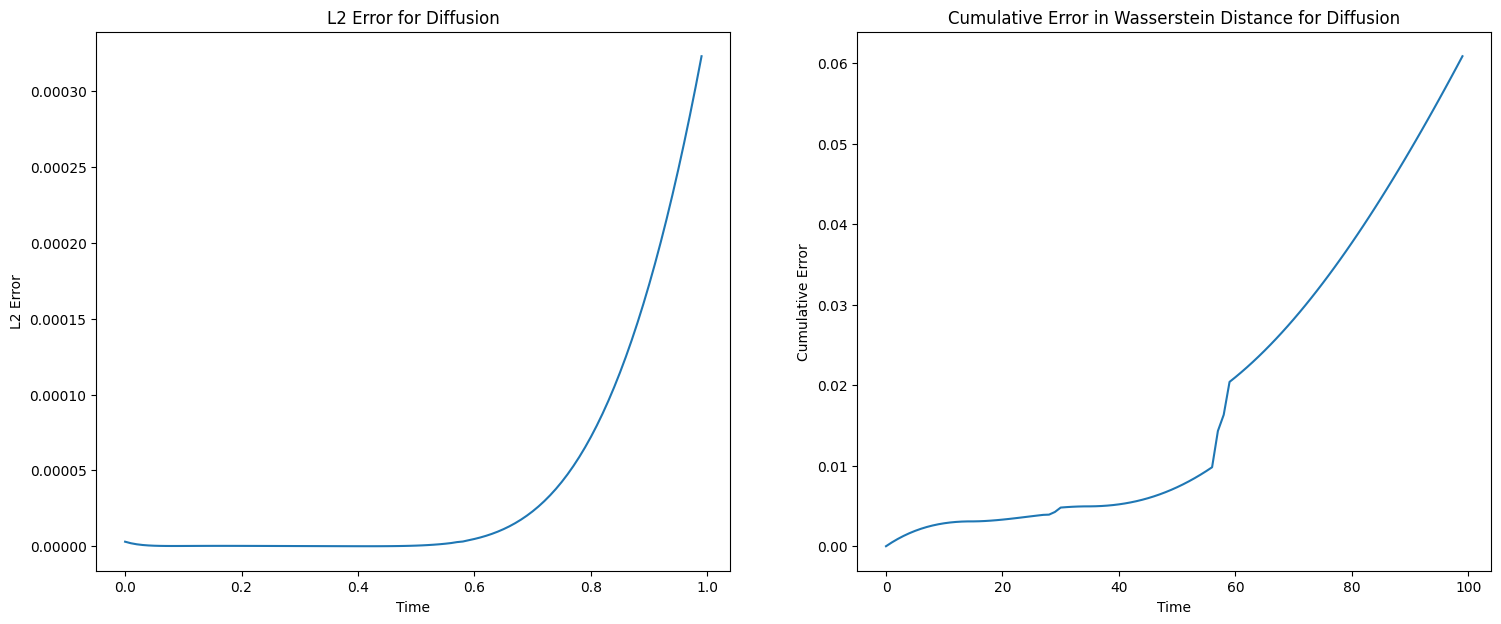

In [ ]:
plot_one_off(diff_matrix, y_true_diff, all_preds_diff[50000].squeeze(), num_x=256, pde="Diffusion")

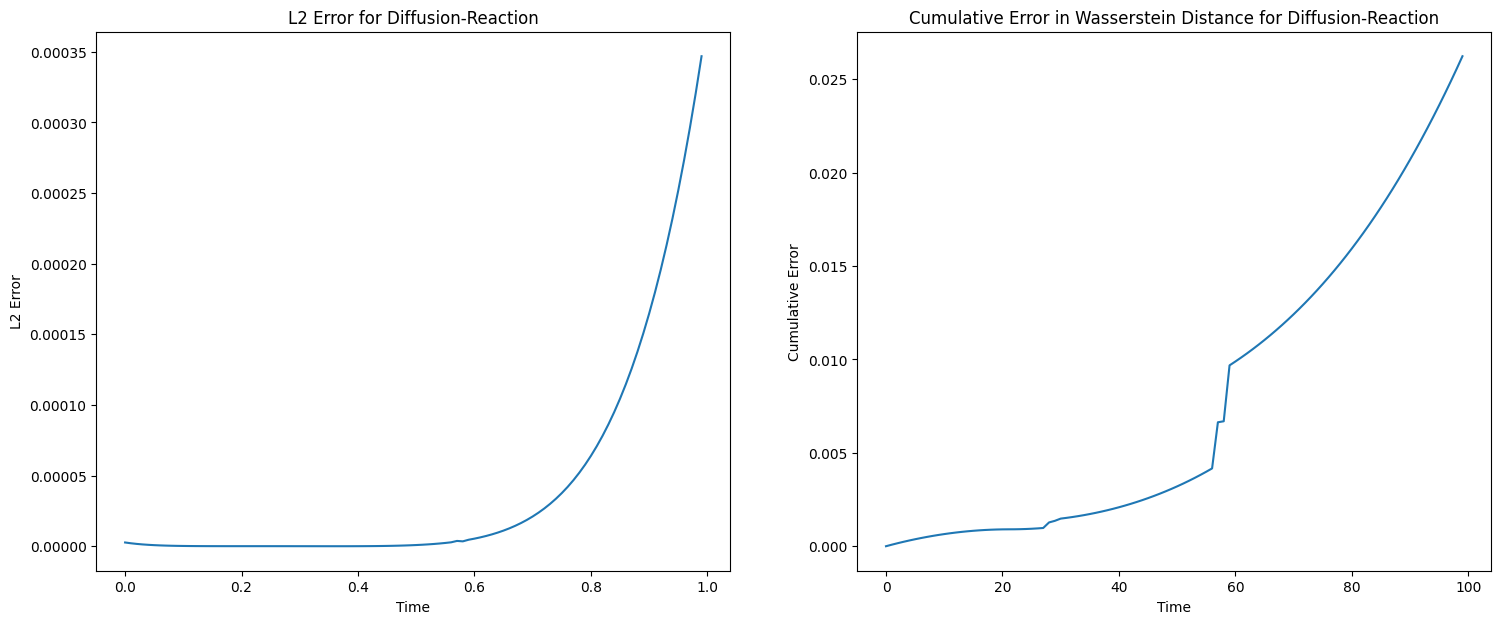

In [ ]:
plot_one_off(diffr_matrix, y_true_diffr, all_preds_diffr[500000].squeeze(), num_x=256, pde="Diffusion-Reaction")

#### Simple Aggregation

In [ ]:
def sum_dist(pairwise_matrix, flipped=False):

  cumulative_errors = []

  if flipped:
    for t1 in range(100):
      cumulative_error = 0
      for t2 in range(99, t1, -1):
        cumulative_error += pairwise_matrix[t1][t2]
      cumulative_errors.append(cumulative_error)
  
  else:
    for t1 in range(100):
      cumulative_error = 0
      for t2 in range(t1):
        cumulative_error += abs(pairwise_matrix[t1][t2])
      cumulative_errors.append(cumulative_error)

  return cumulative_errors

In [ ]:
def max_dist(pairwise_matrix, flipped=False):

  max_errors = []
  
  if flipped:
    for t1 in range(100):
      max_error = 0
      for t2 in range(99, t1, -1):
        max_error = max(abs(pairwise_matrix[t1][t2]), max_error)
      max_errors.append(max_error)

  else:
    for t1 in range(100):
      max_error = 0
      for t2 in range(t1):
        max_error = max(abs(pairwise_matrix[t1][t2]), max_error)
      max_errors.append(max_error)

  return max_errors

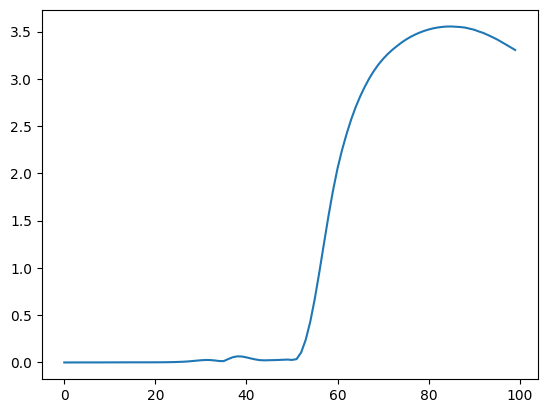

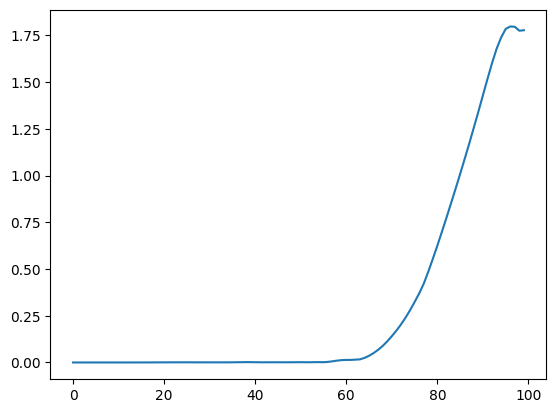

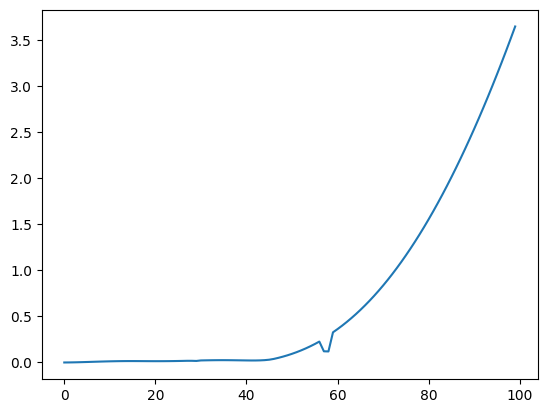

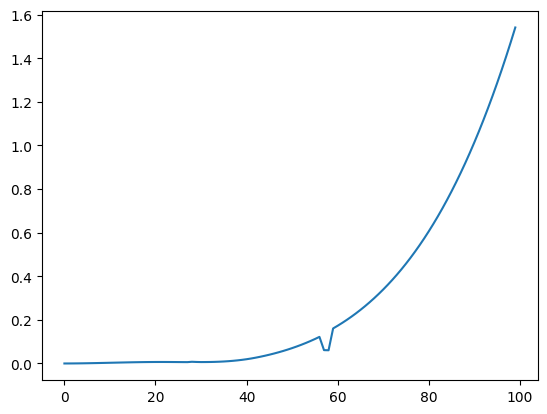

In [ ]:
sum_distances = sum_dist(burgers_matrix)
plt.plot(range(100), abs(np.array(sum_distances)))
plt.show()

sum_distances = sum_dist(ac_matrix)
plt.plot(range(100), abs(np.array(sum_distances)))
plt.show()

sum_distances = sum_dist(diff_matrix)
plt.plot(range(100), abs(np.array(sum_distances)))
plt.show()

sum_distances = sum_dist(diffr_matrix)
plt.plot(range(100), abs(np.array(sum_distances)))
plt.show()

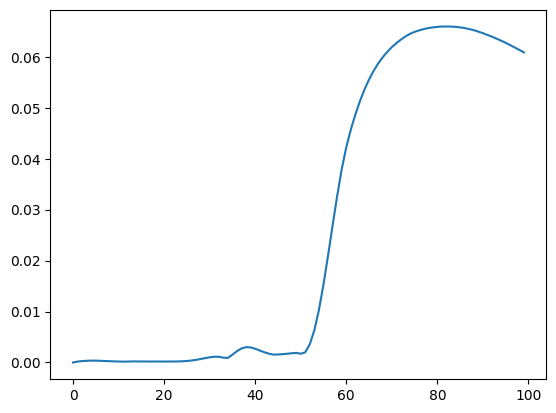

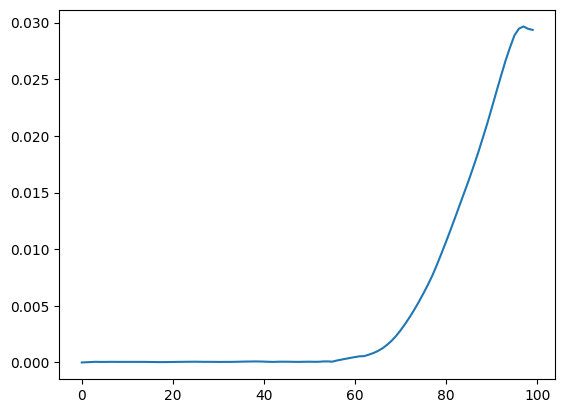

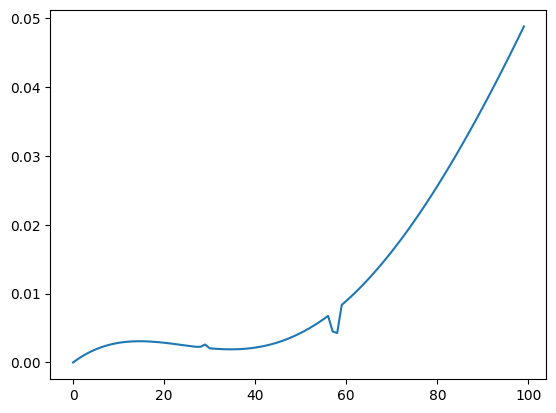

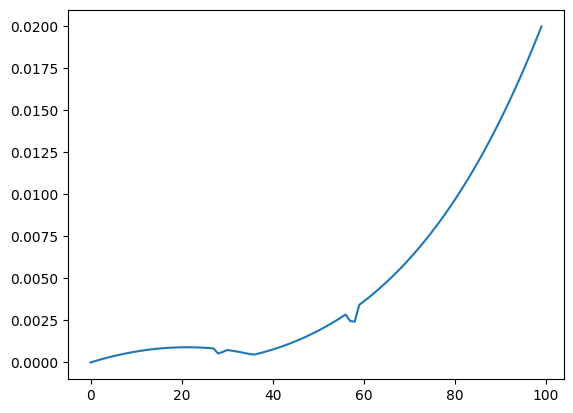

In [ ]:
max_distances = max_dist(burgers_matrix)
plt.plot(range(100), abs(np.array(max_distances)))
plt.show()

max_distances = max_dist(ac_matrix)
plt.plot(range(100), abs(np.array(max_distances)))
plt.show()

max_distances = max_dist(diff_matrix)
plt.plot(range(100), abs(np.array(max_distances)))
plt.show()

max_distances = max_dist(diffr_matrix)
plt.plot(range(100), abs(np.array(max_distances)))
plt.show()

#### Polynomial Regression

In [ ]:
def get_features(pairwise_matrix, true_sol, predicted_sol, num_x, include_time=False):

  l2_errors = l2_error(true_sol, predicted_sol, num_x)

  all_features = []
  all_errors = []

  for t in range(50, 100):
    features = []
    for t2 in range(0, 60, 10):
      features.append(pairwise_matrix[t][t2])
    all_features.append(tuple(features))
    all_errors.append(l2_errors[t])

  return all_features, all_errors

In [ ]:
feats_burgers, errors_burgers = get_features(burgers_matrix, y_true_burgers, all_preds_burgers[500000].squeeze(), num_x=256)
feats_ac, errors_ac = get_features(ac_matrix, y_true_ac, all_preds_ac[500000].squeeze(), num_x=201)
feats_diff, errors_diff = get_features(diff_matrix, y_true_diff, all_preds_diff[500000].squeeze(), num_x=256)
feats_diffr, errors_diffr = get_features(diffr_matrix, y_true_diffr, all_preds_diffr[500000].squeeze(), num_x=256)

weights_burgers = [1/np.var(errors_burgers)] * 50
weights_ac = [1/np.var(errors_ac)] * 50
weights_diff = [1/np.var(errors_diff)] * 50
weights_diffr = [1/np.var(errors_diffr)] * 50

In [ ]:
# errors_burgers = list(errors_burgers/max(errors_burgers))
# errors_ac = list(errors_ac/max(errors_ac))
# errors_diff = list(errors_diff/max(errors_diff))
# errors_diffr = list(errors_diffr/max(errors_diffr))

In [ ]:
all_feats = feats_burgers + feats_ac + feats_diff + feats_diffr
all_errors = errors_burgers + errors_ac + errors_diff + errors_diffr
all_weights = weights_burgers + weights_ac + weights_diff + weights_diffr

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

model = model.fit(all_feats, all_errors, **{'linear__sample_weight': all_weights})
model.named_steps['linear'].coef_

array([ 1.65333791e-03,  3.50692496e+00,  2.62752749e+01,  9.18827319e+00,
       -3.13807202e+01, -6.16589836e+00, -1.03662641e+00,  1.85354904e+03,
        1.23489356e+04,  8.83992173e+03, -2.41306039e+04,  1.02628646e+03,
       -5.32110052e+02, -3.83554670e+04,  3.31221872e+04,  3.37404166e+04,
       -5.04854259e+03,  6.69021992e+03,  1.24728229e+04, -6.54497402e+04,
        6.09778059e+03, -4.14261591e+03,  2.47697299e+04, -3.53581535e+02,
       -3.67902261e+03, -7.33764614e+01,  1.80769370e+03, -1.00429388e+03])

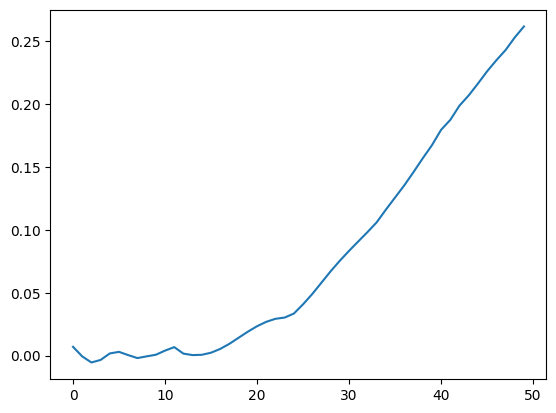

In [ ]:
plt.plot(model.predict(feats_burgers))

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

features_new = np.hstack((np.array(all_feats)**(i+1) for i in range(4)))

model = LinearRegression()
model = model.fit(features_new, all_errors, sample_weight=all_weights)
model.coef_

<ipython-input-58-726ea1691f37>:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  features_new = np.hstack((np.array(all_feats)**(i+1) for i in range(4)))


array([ 2.77745249e-01, -7.67000495e-01,  4.33940739e-01,  1.06000442e+00,
       -1.07466072e+00,  1.86464545e-01,  5.83217489e+01, -3.04396802e+02,
        5.21967406e+02, -3.66971256e+02,  1.39377964e+02, -3.03442192e+01,
       -4.10018318e+03,  4.91434323e+03, -1.23728987e+04,  1.24934203e+04,
        2.99105425e+03, -3.95760807e+03,  2.25063590e+04, -5.21264557e+03,
        1.01791402e+05, -1.56338585e+05,  5.03071962e+04, -1.30758214e+04])

In [ ]:
def model_predict(features):
  features_new = np.hstack((np.array(features)**(i+1) for i in range(4)))
  return model.predict(features_new)

<ipython-input-59-19efdf808446>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  features_new = np.hstack((np.array(features)**(i+1) for i in range(4)))


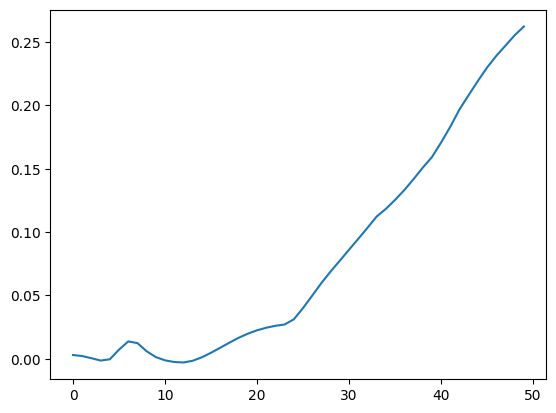

In [ ]:
plt.plot(model_predict(feats_burgers))